In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import pickle
import warnings
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

global model_name, model, dataframe_type, X_train, X_test, y_train, y_test

output_feature = 'Results'

c:\Users\sahil\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataframes = pd.read_pickle('../../data/dataframes.pkl')

In [3]:
models = {
    'random_forest_classifier' : RandomForestClassifier(),
    'ada_boost_classifier' : AdaBoostClassifier(),
    'XGBoost_classifier' : XGBClassifier(),
}

In [4]:
model_params = {}

In [5]:
def objective(trial):

    if model_name == 'ada_boost_classifier':
        params = {
            'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
            'learning_rate' : trial.suggest_float('learning_rate', 0, 1000),
            'algorithm' : trial.suggest_categorical('algorithm', ['SAMME']),
        }
    elif model_name == 'random_forest_classifier':
        params = {
            'n_estimators' : trial.suggest_int('n_estimators', 5, 200),
            'criterion'    : trial.suggest_categorical('criterion', ['log_loss', 'entropy', 'gini']),
            'max_depth'    : trial.suggest_int('max_depth', 1, 100),
            'min_samples_split' : trial.suggest_int('min_samples_split', 2, 100),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 100),
            'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        }
    elif model_name == 'XGBoost_classifier':
        params = {
            "silent": 1,
            "objective": "binary:logistic",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        }
        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
            params["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
            params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        if params["booster"] == "dart":
            params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
            params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # mod = model(**params)
    # mod.fit(X_train, y_train)
    if model_name == 'ada_boost_classifier':
        mod = AdaBoostClassifier(**params)
        mod.fit(X_train, y_train)
    elif model_name == 'random_forest_classifier':
        mod = RandomForestClassifier(**params)
        mod.fit(X_train, y_train)
    elif model_name == 'XGBoost_classifier':
        mod = XGBClassifier(**params)
        mod.fit(X_train, y_train)

    y_pred = mod.predict(X_test)
    # f1_scr = f1_score(y_pred=y_pred, y_true=y_test)
    pre_score = precision_score(y_pred=y_pred, y_true=y_test)

    return pre_score

In [6]:
for df_type, df in zip(dataframes.keys(), dataframes.values()):

    dataframe_type = df_type

    for name, mod in zip(models.keys(), models.values()):

        model_name = name
        model = mod
        # print('{} : {}'.format(dataframe_type, model_name))

        X = df.drop(output_feature, axis=1)
        y = df['Results']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=100)

        trial = study.best_trials[0]
        key = model_name + '-' + dataframe_type
        model_params[key] = trial.params.items()

[I 2024-11-18 21:37:44,256] A new study created in memory with name: no-name-cfaca684-95e0-4e14-9642-6e28137690bb
[I 2024-11-18 21:37:49,528] Trial 0 finished with value: 0.8277511961722488 and parameters: {'n_estimators': 145, 'criterion': 'log_loss', 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 64, 'max_features': None}. Best is trial 0 with value: 0.8277511961722488.
[I 2024-11-18 21:37:51,185] Trial 1 finished with value: 0.8363393453573814 and parameters: {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 77, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 1 with value: 0.8363393453573814.
[I 2024-11-18 21:37:52,119] Trial 2 finished with value: 0.810880829015544 and parameters: {'n_estimators': 93, 'criterion': 'log_loss', 'max_depth': 44, 'min_samples_split': 58, 'min_samples_leaf': 73, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8363393453573814.
[I 2024-11-18 21:37:53,139] Trial 3 finished with value: 0

In [7]:
model_params

{'random_forest_classifier-feat_imp_with_out': dict_items([('n_estimators', 20), ('criterion', 'gini'), ('max_depth', 97), ('min_samples_split', 2), ('min_samples_leaf', 1), ('max_features', 'log2')]),
 'ada_boost_classifier-feat_imp_with_out': dict_items([('n_estimators', 51), ('learning_rate', 397.7515528150233), ('algorithm', 'SAMME')]),
 'XGBoost_classifier-feat_imp_with_out': dict_items([('booster', 'dart'), ('lambda', 0.0008185068327265302), ('alpha', 0.00020655667970421714), ('max_depth', 9), ('eta', 0.45690490462865213), ('gamma', 0.05818398835516519), ('grow_policy', 'lossguide'), ('sample_type', 'uniform'), ('normalize_type', 'tree'), ('rate_drop', 1.1685419901648968e-07), ('skip_drop', 0.003457697592739206)]),
 'random_forest_classifier-feat_imp_without_out': dict_items([('n_estimators', 8), ('criterion', 'log_loss'), ('max_depth', 77), ('min_samples_split', 42), ('min_samples_leaf', 10), ('max_features', None)]),
 'ada_boost_classifier-feat_imp_without_out': dict_items([('n

In [8]:
model_comp = {
    'model_name' : list(),
    'dataframe_type' : list(),
    'metrics' : list(),
    'score' : list()
}

In [9]:
for model_df_type, params in zip(model_params.keys(), model_params.values()):

    model_name, df_type = model_df_type.split('-')
    parameters = dict(params)
    if model_name == 'random_forest_classifier':
        model = RandomForestClassifier(**parameters)
    elif model_name == 'ada_boost_classifier':
        model = AdaBoostClassifier(**parameters)
    elif model_name == 'XGBoost_classifier':
        model = XGBClassifier(**parameters)

    df = dataframes[df_type]
    X = df.drop(output_feature, axis=1)
    y = df[output_feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision_scr = precision_score(y_true=y_test, y_pred=y_pred)
    recall_scr = recall_score(y_true=y_test, y_pred=y_pred)

    model_comp['model_name'].append(model_name)
    model_comp['dataframe_type'].append(df_type)
    model_comp['metrics'].append('precision_score')
    model_comp['score'].append(precision_scr)

    model_comp['model_name'].append(model_name)
    model_comp['dataframe_type'].append(df_type)
    model_comp['metrics'].append('recall_score')
    model_comp['score'].append(recall_scr)
    

In [10]:
model_comp_df = pd.DataFrame(data=model_comp)

model_comp_df.head()

,model_name,dataframe_type,metrics,score
0,random_forest_classifier,feat_imp_with_out,precision_score,0.866667
1,random_forest_classifier,feat_imp_with_out,recall_score,0.900990
2,ada_boost_classifier,feat_imp_with_out,precision_score,1.000000
3,ada_boost_classifier,feat_imp_with_out,recall_score,0.018279
4,XGBoost_classifier,feat_imp_with_out,precision_score,0.881492


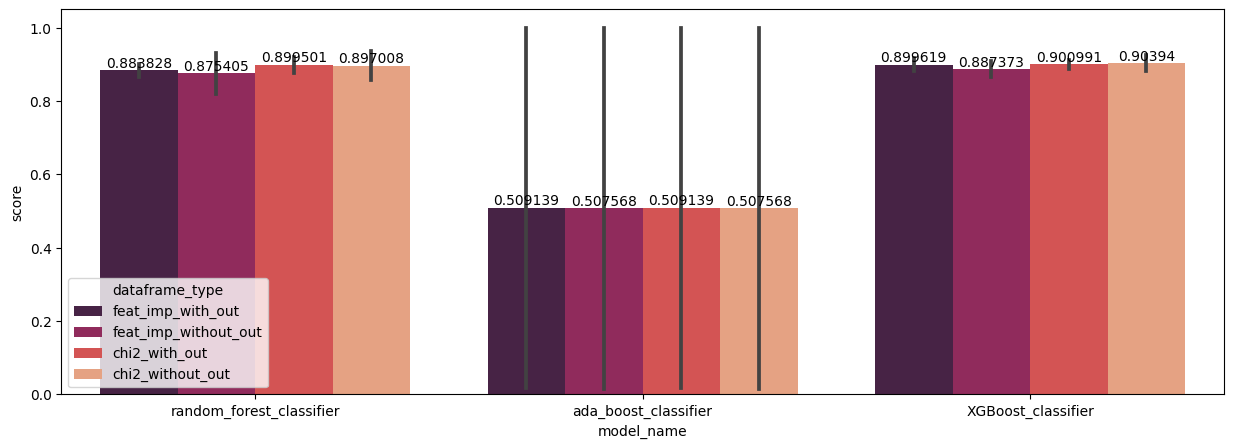

In [11]:
plt.figure(figsize=(15, 5))

ax = sns.barplot(data=model_comp_df, x='model_name', y='score', hue='dataframe_type', palette='rocket')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()